# Stitching using only temp and tuning, try and start with best and work your way through less good compoenents progressively

In [2]:
"""Functions for stitching tca factors together across days."""
%gui asyncio
import random
import numpy as np
import os
import flow
import pandas as pd
from copy import deepcopy
import matplotlib.pyplot as plt
from munkres import Munkres
from cascade import tca
from cascade import paths
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [2]:
# funtion for getting widget ouput after interaction
import asyncio
def wait_for_change(widget, value):
    future = asyncio.Future()
    def getvalue(change):
        # make the new value available
        future.set_result(change.new)
        widget.unobserve(getvalue, value)
    widget.observe(getvalue, value)
    return future

In [3]:
w = widgets.Dropdown(
    options=['1', '2', '3'],
    value='2',
    description='Number:',
    disabled=False,
    )
async def f():
    for i in range(10):
        print('did work %s'%i)
        x = await wait_for_change(w, 'value')
        print('async function continued with value %s'%x)
asyncio.ensure_future(f())

w

Dropdown(description='Number:', index=1, options=('1', '2', '3'), value='2')

In [4]:
from ipywidgets import IntSlider
slider = IntSlider()

async def f():
    for i in range(10):
        print('did work %s'%i)
        x = await wait_for_change(slider, 'value')
        print('async function continued with value %s'%x)
asyncio.ensure_future(f())

slider

IntSlider(value=0)

In [1]:
day1

NameError: name 'day1' is not defined

In [7]:
mouse='OA27'
rank_num=10
match_by='simple_sim'
trace_type='zscore_day'
method='ncp_bcd'
cs=''
warp=False
word='convinced'
"""
Use TCA neuron factor weights and xday alignment
to match TCA components across days.

Uses the best correlation coefficient of weight matrices for matching.

Parameters
----------
mouse, str
    mouse name
rank_num, int
    rank of TCA (number of components) you will align
match_by , str
    type of similarity matrix combination used for matching
    options: tri_sim, tri_sim_prob
trace_type, str
    type of trace used in TCA, used for loading
method, str
    fit method used in TCA, used for loading
    options: 'cp_als', 'ncp_bcd', 'ncp_hals', 'mcp_als'
cs, str
    cses used in TCA, used for loading
    default: '', includes all trials
warp, bool
    warped offsets used in TCA? used for loading
word, str
    hash word for TCA parameters, used for loading

Returns
-------
transition_weights, numpy ndarray
    components x days
temporal_factors, list of numpy ndarray
    [days x time , ...]
sim_mat_by_day, list of numpy ndarray
    [components day 2 x components day 1 , ...]
"""

# pars for loading tca data
pars = {'trace_type': trace_type, 'cs': cs, 'warp': warp}

# create datesorter
days = flow.DateSorter.frommeta(mice=[mouse], tags=None)

conds_by_day = []
oris_by_day = []
trialerr_by_day = []
neuron_ids_by_day = []
neuron_clusters_by_day = []
factors_by_day = []
# loop through days in REVERSE order
for day1 in days[::-1]:

    # load dir
    load_dir = paths.tca_path(mouse, 'single',
                              pars=pars, word=word)
    tensor_path = os.path.join(load_dir, str(day1.mouse)
                               + '_' + str(day1.date)
                               + '_single_decomp_'
                               + str(trace_type) + '.npy')
    input_tensor_path = os.path.join(load_dir, str(day1.mouse)
                                     + '_' + str(day1.date)
                                     + '_single_tensor_'
                                     + str(trace_type) + '.npy')
    input_ids_path = os.path.join(load_dir, str(day1.mouse)
                                  + '_' + str(day1.date)
                                  + '_single_ids_'
                                  + str(trace_type) + '.npy')
    meta_path = os.path.join(load_dir, str(day1.mouse)
                             + '_' + str(day1.date)
                             + '_df_single_meta.pkl')

    # load your metadata, skip post reversal days
    meta = pd.read_pickle(meta_path)
    condition = meta['condition']
    orientation = meta['orientation']
    trialerror = meta['trialerror']
    if 'reversal1' in meta['learning_state'].unique() \
    or 'reversal2' in meta['learning_state'].unique():
        continue

    # skip days that do not have minus, AND neutral
    if 'minus' not in meta['condition'].unique() \
    or 'neutral' not in meta['condition'].unique() \
    or 'plus' not in meta['condition'].unique():
        continue
    
    print(day1.date)
    
    # load your data
    ensemble = np.load(tensor_path)
    ensemble = ensemble.item()
    ids = np.load(input_ids_path)

    # sort neuron factors by component they belong to most
    sort_ensemble, my_sorts = tca._sortfactors(ensemble[method])

    cell_ids = {}  # keys are rank
    cell_clusters = {}
    itr_num = 0  # use only best iteration of TCA, index 0
    for k in sort_ensemble.results.keys():
        # factors are already sorted, so these will define
        # clusters, no need to sort again
        factors = sort_ensemble.results[k][itr_num].factors[0]
        max_fac = np.argmax(factors, axis=1)
        cell_clusters[k] = max_fac
        cell_ids[k] = ids[my_sorts[k-1]]

    neuron_ids_by_day.append(cell_ids[rank_num])
    neuron_clusters_by_day.append(cell_clusters[rank_num])
    factors_by_day.append(sort_ensemble.results[rank_num][0])
    conds_by_day.append(condition)
    oris_by_day.append(orientation)
    trialerr_by_day.append(trialerror)

# ------------------------------------------------------------

# create similarity matrices for comparison of all neuron
# factors weights between a pair of days
on_sim_mat_by_day = []
off_sim_mat_by_day = []
tuning_sim_mat_by_day = []
for i in range(len(factors_by_day)-1):

    # always compare in the time-forward direction
    # (remember that factors_by_day is in reverse order)
    ids1 = neuron_ids_by_day[i+1]
    ids2 = neuron_ids_by_day[i]
    ids1_bool = np.isin(ids1, ids2)
    ids2_bool = np.isin(ids2, ids1)

    # get sort order to match ids between days
    ids1_sort = np.argsort(ids1[ids1_bool])
    ids2_sort = np.argsort(ids2[ids2_bool])

    # get neuron factor weight matrices for ids matched
    # between days
    ids1_weights = factors_by_day[i+1].factors[0][ids1_bool, :]
    ids2_weights = factors_by_day[i].factors[0][ids2_bool, :]

    # get temporal factor weight matrices
    tempo1_weights = factors_by_day[i+1].factors[1][:, :]
    tempo2_weights = factors_by_day[i].factors[1][:, :]

    # get trial factor weight matrices
    trial1_weights = factors_by_day[i+1].factors[2][:, :]
    trial2_weights = factors_by_day[i].factors[2][:, :]
    # get trial factor orientations
    trial1_oris = oris_by_day[i+1]
    trial2_oris = oris_by_day[i]

    # get tuning of trials to 0, 135, 270
    # (mean response per-factor per-ori) / sum(mean responses)
    tuning1_weights = np.zeros((3, rank_num))
    tuning2_weights = np.zeros((3, rank_num))
    oris_to_check = [0, 135, 270]
    for c, ori in enumerate(oris_to_check):
        tuning1_weights[c, :] = np.nanmean(trial1_weights[trial1_oris == ori, :], axis=0)
        tuning2_weights[c, :] = np.nanmean(trial2_weights[trial2_oris == ori, :], axis=0)
    # normalize using summed mean response to all three
    tuning1_total = np.nansum(tuning1_weights, axis=0)
    tuning2_total = np.nansum(tuning2_weights, axis=0)
    for c in range(len(oris_to_check)):
        tuning1_weights[c, :] = np.divide(tuning1_weights[c, :], tuning1_total)
        tuning2_weights[c, :] = np.divide(tuning2_weights[c, :], tuning2_total)
    # make sure 0/0 = 0 rather than nan
    tuning1_weights[np.isnan(tuning1_weights)] = 0
    tuning2_weights[np.isnan(tuning2_weights)] = 0
    # binarize tuning
    tuning1_weights[tuning1_weights > .75] = 1
    tuning2_weights[tuning2_weights > .75] = 1
    tuning1_weights[tuning1_weights <= .75] = 0
    tuning2_weights[tuning2_weights <= .75] = 0
    
    # get dim reduced of temporal sim
    # (max response per-factor for one of three time windows) / sum(3 max responses)
    onset = 15.5
    offset = 15.5*4
    one_sec = 15.5
    buffer = 3
    twin1_weights = np.zeros((3, rank_num))
    twin2_weights = np.zeros((3, rank_num))
    full_window = np.arange(0, np.shape(tempo1_weights)[0])
    windows_to_check = [np.arange(np.floor(onset+buffer), np.floor(onset+one_sec-buffer)),
                        np.arange(np.floor(offset-one_sec+buffer), np.floor(offset-buffer)), 
                        np.arange(np.floor(offset+buffer), np.floor(offset+one_sec*2-buffer))]
    
    for c, win in enumerate(windows_to_check):
        twin1_weights[c, :] = np.nanmean(tempo1_weights[np.isin(full_window,  win), :], axis=0)
        twin2_weights[c, :] = np.nanmean(tempo2_weights[np.isin(full_window, win), :], axis=0)
    # normalize using summed mean response to all three
    twin1_total = np.nansum(twin1_weights, axis=0)
    twin2_total = np.nansum(twin2_weights, axis=0)
    for c in range(len(windows_to_check)):
        twin1_weights[c, :] = np.divide(twin1_weights[c, :], twin1_total)
        twin2_weights[c, :] = np.divide(twin2_weights[c, :], twin2_total)
    # make sure 0/0 = 0 rather than nan
    twin1_weights[np.isnan(twin1_weights)] = 0
    twin2_weights[np.isnan(twin2_weights)] = 0
    # deal with offset weights and vis stim driven separately
    off1_weights = deepcopy(twin1_weights)
    off2_weights = deepcopy(twin2_weights)
    on1_weights = deepcopy(twin1_weights)
    on2_weights = deepcopy(twin2_weights)
    on1_weights[:, np.argmax(twin1_weights, axis=0) == 2] = 0
    on2_weights[:, np.argmax(twin2_weights, axis=0) == 2] = 0
    off1_weights[:, np.argmax(twin1_weights, axis=0) != 2] = 0
    off2_weights[:, np.argmax(twin2_weights, axis=0) != 2] = 0
    
    # get the correlation matrix for different days
    # do the full comparison with both days then select
    # only the off-diagonal quadrant of the correlation matrix
    # so you are only comparing day1-day2 factors rather than
    # day2-day1
#     on_corr = np.corrcoef(on1_weights.T, y=on2_weights.T)
#     on_corr = deepcopy(on_corr[-rank_num:, 0:rank_num])
#     on_corr[np.isnan(on_corr)] = 0
#     on_sim_mat_by_day.append(deepcopy(on_corr[-rank_num:, 0:rank_num]))
    on_sim_mat_by_day.append(on2_weights.T @ on1_weights)
    
#     off_corr = np.corrcoef(off1_weights.T, y=off2_weights.T)
#     off_corr[np.isnan(off_corr)] = 0
#     off_sim_mat_by_day.append(deepcopy(off_corr[-rank_num:, 0:rank_num]))
    off_sim_mat_by_day.append(off2_weights.T @ off1_weights)


#     tuning_corr = np.corrcoef(tuning1_weights.T, y=tuning2_weights.T)
#     tuning_corr[np.isnan(tuning_corr)] = 0
#     tuning_sim_mat_by_day.append(deepcopy(tuning_corr[-rank_num:, 0:rank_num]))
    tuning_sim_mat_by_day.append(tuning2_weights.T @ tuning1_weights)

# ------------------------------------------------------------

if match_by == 'simple_sim':
# elementwise multiplication of the onsets & tuning matrices
    match_mat = [np.multiply(b, c) for b, c in zip(on_sim_mat_by_day, tuning_sim_mat_by_day)]
else:
    print('Unregognized matching method in match_by.')
#     return


temporal_factors_list = []
transition_weights = np.zeros((np.shape(match_mat[0])[0], len(match_mat)))
# factors_by_day_ = factors_by_day[::-1]
for comp_num in range(np.shape(match_mat[0])[0]):
    temporal_factors = []
    for i in range(len(match_mat)):
        # get similarity matrices. (i.e., [day1-->day2])
        # reverse order matching, forward in time.
        sim_mat = match_mat[i]
        if i == 0:
            starting_comp = np.argmax(sim_mat[comp_num, :])
            starting_weight = np.max(sim_mat[comp_num, :])
            starting_sort = np.sort(sim_mat[comp_num, :])[::-1]
            one_two_ratio = starting_sort[0]/(starting_sort[0] + starting_sort[1])
            if starting_sort[0] == 0:
                print('Skipped bad component start - ' + str(comp_num))
                temporal_factors_list.append(temporal_factors[::-1])
                break
            if one_two_ratio <= 0.6:
                print('Skipped bad component ratio start - ' + str(comp_num))
                temporal_factors_list.append(temporal_factors[::-1])
                break
            transition_weights[comp_num, i] = sim_mat[comp_num, starting_comp]
            fac_1 = factors_by_day[i+1].factors[1][:, starting_comp]
            fac_2 = factors_by_day[i].factors[1][:, comp_num]
            temporal_factors.append(fac_2)
            temporal_factors.append(fac_1)
        else:
            new_starting_comp = np.argmax(sim_mat[starting_comp, :])
            new_starting_sort = np.sort(sim_mat[starting_comp, :])[::-1]
            one_two_ratio = new_starting_sort[0]/(new_starting_sort[0] + new_starting_sort[1])
            if new_starting_sort[0] == 0:
                print('Skipped bad component - ' + str(comp_num))
                temporal_factors_list.append(temporal_factors[::-1])
                break ###### THIS NEEDS TO BE UPDATED SO THAT THIS COMPARISON HAPPENS IN LOOP SO THAT DAY1--DAY3 can be checked
            if one_two_ratio <= 0.6: #
                print('Skipped bad component ratio - ' + str(comp_num))
                temporal_factors_list.append(temporal_factors[::-1])
                break
            transition_weights[comp_num, i] = sim_mat[starting_comp, new_starting_comp]
            fac_n = factors_by_day[i+1].factors[1][:, new_starting_comp]
            temporal_factors.append(fac_n)
            starting_comp = new_starting_comp

    temporal_factors_list.append(temporal_factors[::-1])


170308
170303
170224
170223
170220
170217
170216
170215
170214
170211
170210
170209
170208
170207
170206
170204
170125
170119
170118
170116
Skipped bad component ratio - 0
Skipped bad component start - 1
Skipped bad component ratio start - 2
Skipped bad component ratio - 3
Skipped bad component start - 4
Skipped bad component start - 5
Skipped bad component start - 6
Skipped bad component ratio - 7
Skipped bad component start - 8
Skipped bad component ratio start - 9


/Users/kelly_mcguire/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:263: RuntimeWarning: invalid value encountered in double_scalars


In [117]:
np.shape(temporal_factors_list)

(10,)

In [ ]:
for i in range(len(temporal_factors_list)):
    if len(temporal_factors_list[i]) != 0:
        plt.figure()
        plt.imshow(temporal_factors_list[i], aspect='auto')
        plt.title(str(i))
        plt.colorbar()
# for i in range(len(temporal_factors_list)):
#     if len(match_mat[i]) != 0:
#         plt.figure()
#         plt.imshow(match_mat[i], aspect='auto')
#         plt.title(str(i))
#         plt.colorbar()

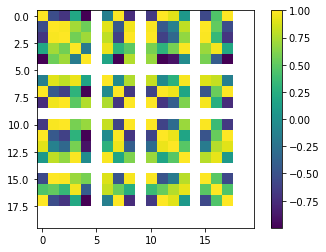

In [99]:
plt.imshow(np.corrcoef(on1_weights.T, y=on2_weights.T))
plt.colorbar()

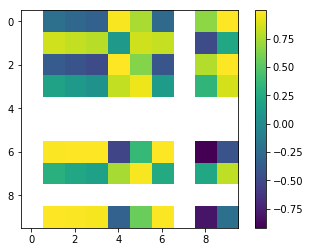

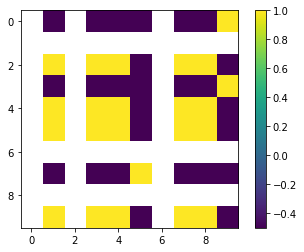

In [91]:
# test = tuning1_weights.T @ tuning2_weights
# test2 = twin1_weights.T @ twin2_weights
# test3 = np.multiply(test, test2
plt.figure()
plt.imshow(on_sim_mat_by_day[0])
plt.colorbar()
plt.figure()
plt.imshow(tuning_sim_mat_by_day[0])
plt.colorbar()

[0. 0. 0.]
[0. 0. 0.]


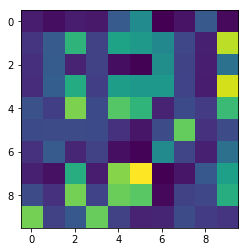

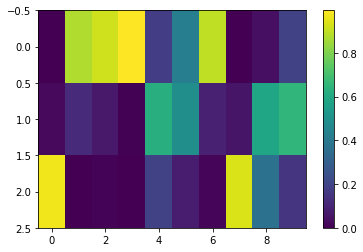

In [65]:
plt.figure()
plt.imshow(np.concatenate((twin1_weights, tuning1_weights), axis=0).T @ np.concatenate((twin2_weights, tuning2_weights), axis=0))
plt.figure()
plt.imshow(twin1_weights, aspect='auto')
plt.colorbar()
print(tuning1_weights[:,0])
print(tuning1_weights[:,2])

In [37]:
np.shape(np.concatenate((twin1_weights, tuning1_weights), axis=1))

(3, 20)

In [ ]:
    # get the correlation matrix for different days
    # do the full comparison with both days then select
    # only the off-diagonal quadrant of the correlation matrix
    # so you are only comparing day1-day2 factors rather than
    # day2-day1
    on_corr = np.corrcoef(on1_weights.T, y=on2_weights.T)
    on_sim_mat_by_day.append(deepcopy(on_corr[-rank_num:, 0:rank_num]))
    
    off_corr = np.corrcoef(off1_weights.T, y=off2_weights.T)
    off_sim_mat_by_day.append(deepcopy(off_corr[-rank_num:, 0:rank_num]))

    tuning_corr = np.corrcoef(tuning1_weights.T, y=tuning2_weights.T)
    sim_mat_tempo_by_day.append(deepcopy(tuning_corr[-rank_num:, 0:rank_num]))


    # find transiiton probabilities by asking which factors
    # are matched (without replacement) in random shuffled order.
    # this will allow for balancing of components with
    # similar weights
    sz = ids_corr[-rank_num:, 0:rank_num]
    my_sort = np.zeros(np.shape(sz)[0], dtype=np.int64)
    bins = np.empty(np.shape(sz)[0])
    bins = np.empty((boot_num, np.shape(sz)[0]))
    bins[:] = np.nan
    # iterate multiple times, saving results into "bins"
    for it in range(boot_num):
        corner = deepcopy(ids_corr[-rank_num:, 0:rank_num])
        for k in random.sample(list(range(np.shape(corner)[0])),
                               np.shape(corner)[0]):
            pos = np.argmax(corner[:, k])
            bins[it, k] = pos
            corner[pos, :] = 0
    # take mean of each occurance of pos by the number of
    # iterations to get the probabilty of matching to
    # that cluster
    prob_mat = np.zeros((np.shape(corner)))
    for k in range(np.shape(corner)[0]):
        prob_mat[k, :] = np.mean(bins == k, axis=0)
    prob_mat_by_day.append(prob_mat)

# ------------------------------------------------------------

# align: get factor index, stepping through similarity
# matrices for pairs of days
if match_by == 'bi_sim':
    # elementwise multiplication of the prob & sim mat
    # match_mat = [a*b*c for a, b, c in zip(sim_mat_neuro_by_day, sim_mat_neuro_by_day, sim_mat_trial_tuning_by_day)]
    match_mat = [(b*0.9+c*0.1)/2 for b, c in zip(sim_mat_tempo_by_day, sim_mat_trial_tuning_by_day)]
elif match_by == 'tri_sim_prob':
    # elementwise multiplication of the prob & sim mat
    match_mat = [a*b*c*d for a, b, c, d in zip(sim_mat_neuro_by_day, sim_mat_tempo_by_day, sim_mat_trial_tuning_by_day, prob_mat_by_day)]
else:
    print('Unregognized matching method in match_by.')
#     return


temporal_factors_list = []
transition_weights = np.zeros((np.shape(match_mat[0])[0], len(match_mat)))
# factors_by_day_ = factors_by_day[::-1]
for comp_num in range(np.shape(match_mat[0])[0]):
    temporal_factors = []
    for i in range(len(match_mat)):
        # get similarity matrices. (i.e., [day1-->day2])
        # reverse order matching, forward in time.
        sim_mat = match_mat[i]
        if i == 0:
            starting_comp = np.argmax(sim_mat[comp_num, :])
            transition_weights[comp_num, i] = sim_mat[comp_num, starting_comp]
            fac_1 = factors_by_day[i+1].factors[1][:, starting_comp]
            fac_2 = factors_by_day[i].factors[1][:, comp_num]
            temporal_factors.append(fac_2)
            temporal_factors.append(fac_1)
        else:
            new_starting_comp = np.argmax(sim_mat[starting_comp, :])
            transition_weights[comp_num, i] = sim_mat[starting_comp, new_starting_comp]
            fac_n = factors_by_day[i+1].factors[1][:, new_starting_comp]
            temporal_factors.append(fac_n)
            starting_comp = new_starting_comp

    temporal_factors_list.append(temporal_factors[::-1])

# reverse order of output variables so they are correct
# [day1, day2, day3, etc]
transition_weights = transition_weights[:, ::-1]
temporal_factors_list = temporal_factors_list[::-1]
sim_mat_neuro_by_day = sim_mat_neuro_by_day[::-1]
sim_mat_tempo_by_day = sim_mat_tempo_by_day[::-1]
sim_mat_trial_tuning_by_day = sim_mat_trial_tuning_by_day[::-1]
match_mat = match_mat[::-1]

# return {'trans': transition_weights,
#         'tempo_fac': temporal_factors_list,
#         'neuro_sim': sim_mat_neuro_by_day,
#         'tempo_sim': sim_mat_tempo_by_day,
#         'ttuning_sim': sim_mat_trial_tuning_by_day,
#         'tri_sim': match_mat
#         }

In [30]:
len(match_mat)

19

In [ ]:
plt.figure()
for i in range(len(temporal_factors_list)):
    plt.figure()
    plt.imshow(temporal_factors_list[i], aspect='auto')

# using forward direction algorithm

In [13]:
mouse='OA27'
rank_num=10
trace_type='zscore_day'
method='ncp_bcd'
cs=''
warp=False
word='convinced'
match_by = 'tuning_simple'
days[0].tags


True

In [30]:
days = flow.DateSorter.frommeta(mice=[mouse], tags='naive')
days.extend(flow.DateSorter.frommeta(mice=[mouse], tags='learning'))
dates = set(days)
dates

{Date(mouse='OA27', date=170116, tags=('kelly', 'naive'), photometry=()),
 Date(mouse='OA27', date=170118, tags=('kelly', 'naive'), photometry=()),
 Date(mouse='OA27', date=170119, tags=('kelly', 'naive'), photometry=()),
 Date(mouse='OA27', date=170125, tags=('kelly', 'learning_start'), photometry=()),
 Date(mouse='OA27', date=170127, tags=('hungry', 'kelly', 'learning'), photometry=()),
 Date(mouse='OA27', date=170128, tags=('hungry', 'kelly', 'learning'), photometry=()),
 Date(mouse='OA27', date=170129, tags=('hungry', 'kelly', 'learning'), photometry=()),
 Date(mouse='OA27', date=170131, tags=('hungry', 'kelly', 'learning'), photometry=()),
 Date(mouse='OA27', date=170201, tags=('hungry', 'kelly', 'learning'), photometry=()),
 Date(mouse='OA27', date=170202, tags=('hungry', 'kelly', 'learning'), photometry=()),
 Date(mouse='OA27', date=170204, tags=('hungry', 'kelly', 'learning'), photometry=()),
 Date(mouse='OA27', date=170206, tags=('hungry', 'kelly', 'learning'), photometry=()),

In [31]:
days = flow.DateSorter(dates=dates)
days[0]

Date(mouse='OA27', date=170116, tags=('kelly', 'naive'), photometry=())

In [3]:
# pars for loading tca data
pars = {'trace_type': trace_type, 'cs': cs, 'warp': warp}

# create datesorter
days = flow.DateSorter.frommeta(mice=[mouse], tags=None)

conds_by_day = []
oris_by_day = []
trialerr_by_day = []
neuron_ids_by_day = []
neuron_clusters_by_day = []
factors_by_day = []
speed_by_day = []
day_list = []
# loop through days in FORWARD order
for day1 in days:

    # load dir
    load_dir = paths.tca_path(mouse, 'single',
                              pars=pars, word=word)
    tensor_path = os.path.join(load_dir, str(day1.mouse)
                               + '_' + str(day1.date)
                               + '_single_decomp_'
                               + str(trace_type) + '.npy')
    input_tensor_path = os.path.join(load_dir, str(day1.mouse)
                                     + '_' + str(day1.date)
                                     + '_single_tensor_'
                                     + str(trace_type) + '.npy')
    input_ids_path = os.path.join(load_dir, str(day1.mouse)
                                  + '_' + str(day1.date)
                                  + '_single_ids_'
                                  + str(trace_type) + '.npy')
    meta_path = os.path.join(load_dir, str(day1.mouse)
                             + '_' + str(day1.date)
                             + '_df_single_meta.pkl')

    # load your metadata, skip post reversal days
    meta = pd.read_pickle(meta_path)
    condition = meta['condition']
    orientation = meta['orientation']
    trialerror = meta['trialerror']
    speed = meta['speed']
    if 'reversal1' in meta['learning_state'].unique() \
    or 'reversal2' in meta['learning_state'].unique():
        continue

    # skip days that do not have minus, AND neutral
    if 'minus' not in meta['condition'].unique() \
    or 'neutral' not in meta['condition'].unique() \
    or 'plus' not in meta['condition'].unique():
        continue
    
    # keep dates for user
    day_list.append(day1.date)
    
    # load your data
    ensemble = np.load(tensor_path)
    ensemble = ensemble.item()
    ids = np.load(input_ids_path)

    # sort neuron factors by component they belong to most
    sort_ensemble, my_sorts = tca._sortfactors(ensemble[method])

    cell_ids = {}  # keys are rank
    cell_clusters = {}
    itr_num = 0  # use only best iteration of TCA, index 0
    for k in sort_ensemble.results.keys():
        # factors are already sorted, so these will define
        # clusters, no need to sort again
        factors = sort_ensemble.results[k][itr_num].factors[0]
        max_fac = np.argmax(factors, axis=1)
        cell_clusters[k] = max_fac
        cell_ids[k] = ids[my_sorts[k-1]]

    neuron_ids_by_day.append(cell_ids[rank_num])
    neuron_clusters_by_day.append(cell_clusters[rank_num])
    factors_by_day.append(sort_ensemble.results[rank_num][0])
    conds_by_day.append(condition)
    oris_by_day.append(orientation)
    trialerr_by_day.append(trialerror)
    speed_by_day.append(speed)

# ------------------------------------------------------------

# get all pairwise similarity matrices for tuning and dim-reduced temporal factors
# this should be done on a time forward vector and can include reversal
tempo_sim_mats_by_day = []
on_sim_mats_by_day = []
off_sim_mats_by_day = []
tuning_sim_mats_by_day = []
fano_sim_mats_by_day = []
for k in range(len(factors_by_day)):

    # sim mats, day k comps are columns, day i comps are rows
    sim_mats_tempo = np.zeros((rank_num, rank_num, len(factors_by_day)))
    sim_mats_on = np.zeros((rank_num, rank_num, len(factors_by_day)))
    sim_mats_off = np.zeros((rank_num, rank_num, len(factors_by_day)))
    sim_mats_tuning = np.zeros((rank_num, rank_num, len(factors_by_day)))
    sim_mats_fano = np.zeros((rank_num, rank_num, len(factors_by_day)))
    
    for i in range(len(factors_by_day)):

        # always compare in the time-forward direction
        ids1 = neuron_ids_by_day[k]
        ids2 = neuron_ids_by_day[i]
        ids1_bool = np.isin(ids1, ids2)
        ids2_bool = np.isin(ids2, ids1)

        ids1_sort = np.argsort(ids1[ids1_bool])
        ids2_sort = np.argsort(ids2[ids2_bool])

        ids1_weights = factors_by_day[k].factors[0][ids1_bool,:]
        ids2_weights = factors_by_day[i].factors[0][ids2_bool,:]
       # get temporal factor weight matrices
        tempo1_weights = factors_by_day[k].factors[1][:, :]
        tempo2_weights = factors_by_day[i].factors[1][:, :]
        
        # get trial factor weight matrices
        trial1_weights = factors_by_day[k].factors[2][:, :]
        trial2_weights = factors_by_day[i].factors[2][:, :]
        
        highspeed = 10 # WHAT OF THE ANIMAL ONLY RUNS OR ONLY STANDS
        speed1 = speed_by_day[k]
        speed2 = speed_by_day[i]
        sc_run = np.nanmean(trial1_weights[speed1 >= highspeed, :], axis=0)
        if np.sum(np.isnan(sc_run)) > 0 :
            sc_run = np.nanmean(trial1_weights[:, :], axis=0)
        sc_not_run = np.nanmean(trial1_weights[speed1 < highspeed, :], axis=0)
        if np.sum(np.isnan(sc_run)) > 0:
            sc_not_run = np.nanmean(trial1_weights[:, :], axis=0)
        tempo1_weighted = np.concatenate((tempo1_weights*sc_run, tempo1_weights*sc_not_run), axis=0)
        sc_run = np.nanmean(trial2_weights[speed2 >= highspeed, :], axis=0)
        if np.sum(np.isnan(sc_run)) > 0:
            sc_run = np.nanmean(trial2_weights[:, :], axis=0)
        sc_not_run = np.nanmean(trial2_weights[speed2 < highspeed, :], axis=0)
        if np.sum(np.isnan(sc_not_run)) > 0:
            sc_not_run = np.nanmean(trial2_weights[:, :], axis=0)
        tempo2_weighted = np.concatenate((tempo2_weights*sc_run, tempo2_weights*sc_not_run), axis=0)
        
        break
    break

#         # get trial factor orientations
#         trial1_oris = oris_by_day[k]
#         trial2_oris = oris_by_day[i]
        
#         # ---------------

#         # get tuning of trials to 0, 135, 270
#         # (mean response per-factor per-ori) / sum(mean responses)
#         tuning1_weights = np.zeros((3, rank_num))
#         tuning2_weights = np.zeros((3, rank_num))
#         oris_to_check = [0, 135, 270]
#         for c, ori in enumerate(oris_to_check):
#             tuning1_weights[c, :] = np.nanmean(trial1_weights[trial1_oris == ori, :], axis=0)
#             tuning2_weights[c, :] = np.nanmean(trial2_weights[trial2_oris == ori, :], axis=0)
#         # normalize using summed mean response to all three
#         tuning1_total = np.nansum(tuning1_weights, axis=0)
#         tuning2_total = np.nansum(tuning2_weights, axis=0)
#         for c in range(len(oris_to_check)):
#             tuning1_weights[c, :] = np.divide(tuning1_weights[c, :], tuning1_total)
#             tuning2_weights[c, :] = np.divide(tuning2_weights[c, :], tuning2_total)
#         # make sure 0/0 = 0 rather than nan
#         tuning1_weights[np.isnan(tuning1_weights)] = 0
#         tuning2_weights[np.isnan(tuning2_weights)] = 0
#         # binarize tuning
# #         tuning1_weights[tuning1_weights > .5] = 1
# #         tuning2_weights[tuning2_weights > .5] = 1
# #         tuning1_weights[tuning1_weights <= .5] = 0
# #         tuning2_weights[tuning2_weights <= .5] = 0

#         # ---------------
        
#         # get fanofactor of trials to 0, 135, 270
#         # (mean response per-factor per-ori) / sum(mean responses)
#         tuning1_fano = np.zeros((1, rank_num))
#         tuning2_fano = np.zeros((1, rank_num))
#         c = 0
#         oris_to_check = [0, 135, 270]
# #         for c, ori in enumerate(oris_to_check):
# #             tuning1_fano[c, :] = (np.nanvar(trial1_weights[trial1_oris == ori, :], axis=0)/ 
# #                                      np.nanmean(trial1_weights[trial1_oris == ori, :], axis=0))
# #             tuning2_fano[c, :] = (np.nanvar(trial2_weights[trial2_oris == ori, :], axis=0)/
# #                                      np.nanmean(trial2_weights[trial2_oris == ori, :], axis=0))
#         tuning1_fano[c, :] = (np.nanvar(trial1_weights[:, :], axis=0)/ 
#                             np.nanmean(trial1_weights[:, :], axis=0))
#         tuning2_fano[c, :] = (np.nanvar(trial2_weights[:, :], axis=0)/
#                              np.nanmean(trial2_weights[:, :], axis=0))
#         # make sure 0/0 = 0 rather than nan
#         tuning1_fano[np.isnan(tuning1_fano)] = 0
#         tuning2_fano[np.isnan(tuning2_fano)] = 0

#         # ---------------
        
#         # get dim reduced temporal similarity
#         # (max response per-factor for one of three time windows) / sum(3 max responses)
#         onset = 15.5
#         offset = 15.5*4
#         one_sec = 15.5
#         buffer = 3
#         twin1_weights = np.zeros((3, rank_num))
#         twin2_weights = np.zeros((3, rank_num))
#         full_window = np.arange(0, np.shape(tempo1_weights)[0])
#         windows_to_check = [np.arange(np.floor(onset+buffer), np.floor(onset+one_sec-buffer)),
#                             np.arange(np.floor(offset-one_sec+buffer), np.floor(offset-buffer)), 
#                             np.arange(np.floor(offset+buffer), np.floor(offset+one_sec*2-buffer))]

#         for c, win in enumerate(windows_to_check):
#             twin1_weights[c, :] = np.nanmax(tempo1_weights[np.isin(full_window,  win), :], axis=0)
#             twin2_weights[c, :] = np.nanmax(tempo2_weights[np.isin(full_window, win), :], axis=0)
#         # normalize using summed mean response to all three
#         twin1_total = np.nansum(twin1_weights, axis=0)
#         twin2_total = np.nansum(twin2_weights, axis=0)
#         for c in range(len(windows_to_check)):
#             twin1_weights[c, :] = np.divide(twin1_weights[c, :], twin1_total)
#             twin2_weights[c, :] = np.divide(twin2_weights[c, :], twin2_total)
#         # make sure 0/0 = 0 rather than nan
#         twin1_weights[np.isnan(twin1_weights)] = 0
#         twin2_weights[np.isnan(twin2_weights)] = 0
#         # deal with offset weights and vis stim driven separately
#         off1_weights = deepcopy(twin1_weights)
#         off2_weights = deepcopy(twin2_weights)
#         on1_weights = deepcopy(twin1_weights)
#         on2_weights = deepcopy(twin2_weights)
#         on1_weights[:, np.argmax(twin1_weights, axis=0) == 2] = 0
#         on2_weights[:, np.argmax(twin2_weights, axis=0) == 2] = 0
#         off1_weights[:, np.argmax(twin1_weights, axis=0) != 2] = 0
#         off2_weights[:, np.argmax(twin2_weights, axis=0) != 2] = 0

        
#         # calculate similarity matrices 
# #         sim_mats_on[:, :, i] = on2_weights.T @ on1_weights
# #         sim_mats_off[:, :, i] = off2_weights.T @ off1_weights
# #         sim_mats_tuning[:, :, i] = tuning2_weights.T @ tuning1_weights
# #         sim_mats_fano[:, :, i] = tuning2_fano.T @ tuning1_fano
        
#         # calculate similarity matrices
#         sim_mats_tempo[:, :, i] = deepcopy(np.corrcoef(tempo1_weights.T, y=tempo2_weights.T)[-rank_num:, 0:rank_num])
#         sim_mats_on[:, :, i] = deepcopy(np.corrcoef(on1_weights.T, y=on2_weights.T)[-rank_num:, 0:rank_num])
#         sim_mats_off[:, :, i] = deepcopy(np.corrcoef(off1_weights.T, y=off2_weights.T)[-rank_num:, 0:rank_num])
#         sim_mats_tuning[:, :, i] = deepcopy(np.corrcoef(tuning1_weights.T, y=tuning2_weights.T)[-rank_num:, 0:rank_num])
#         sim_mats_fano[:, :, i] = deepcopy(np.corrcoef(tuning1_fano.T, y=tuning2_fano.T)[-rank_num:, 0:rank_num])
#         sim_mats_on[np.isnan(sim_mats_on)] = 0
#         sim_mats_off[np.isnan(sim_mats_off)] = 0
#         sim_mats_tuning[np.isnan(sim_mats_tuning)] = 0
#         sim_mats_fano[np.isnan(sim_mats_fano)] = 0
    
#     tempo_sim_mats_by_day.append(sim_mats_tempo)
#     on_sim_mats_by_day.append(sim_mats_on)
#     off_sim_mats_by_day.append(sim_mats_off)
#     tuning_sim_mats_by_day.append(sim_mats_tuning)
#     fano_sim_mats_by_day.append(sim_mats_fano)

# # ------------------------------------------------------------

# if match_by == 'all_sim':
# # elementwise multiplication of the (onsets + offsets) & tuning matrices
#     sim_mats_by_day = [np.multiply((a + b), c) for a, b, c in zip(on_sim_mats_by_day, off_sim_mats_by_day, tuning_sim_mats_by_day)]
# elif match_by == 'on_sim':
#     # elementwise multiplication of the (onsets) & tuning matrices
#     sim_mats_by_day = [np.multiply(a, c) for a, c in zip(on_sim_mats_by_day , tuning_sim_mats_by_day)]
# elif match_by == 'on_sim':
#     # elementwise multiplication of the (offsets) & tuning matrices
#     sim_mats_by_day = [np.multiply(b, c) for b, c in zip(off_sim_mats_by_day, tuning_sim_mats_by_day)]
# elif match_by == 'tuning_simple':
#     # elementwise multiplication of the (offsets) & tuning matrices
#     sim_mats_by_day = [c for c in tuning_sim_mats_by_day]
# else:
#     print('Unregognized matching method in match_by.')
# #     return

# # ------------------------------------------------------------

NameError: name 'trace_type' is not defined

In [122]:
tempo1_weighted

array([[0.00000000e+00, 0.00000000e+00, 1.81242157e-05, ...,
        4.54894709e-03, 0.00000000e+00, 0.00000000e+00],
       [4.23690944e-03, 5.90933113e-04, 0.00000000e+00, ...,
        9.34258529e-03, 8.02446744e-05, 0.00000000e+00],
       [0.00000000e+00, 5.23907705e-04, 0.00000000e+00, ...,
        9.05636717e-03, 3.14157517e-03, 0.00000000e+00],
       ...,
       [           nan,            nan,            nan, ...,
                   nan,            nan,            nan],
       [           nan,            nan,            nan, ...,
                   nan,            nan,            nan],
       [           nan,            nan,            nan, ...,
                   nan,            nan,            nan]])

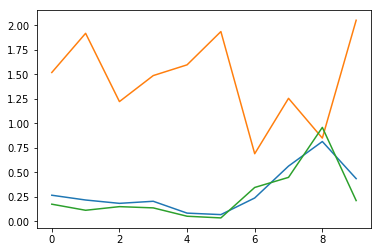

In [91]:
ori = 0
s = (np.nanvar(trial1_weights[trial1_oris == ori, :], axis=0)/ 
np.nanmean(trial1_weights[trial1_oris == ori, :], axis=0))
v = (np.nanvar(trial1_weights, axis=0)/ 
     np.nanmean(trial1_weights, axis=0))
plt.figure()
plt.plot(s)
plt.plot(v)
plt.plot(s/v)

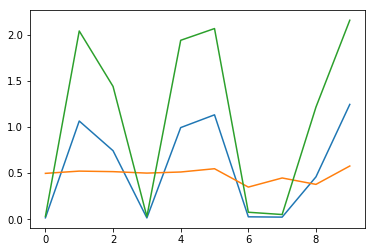

In [50]:
ori = 270
s = (np.nanvar(trial1_weights[trial1_oris == ori, :], axis=0))
v = (np.nanvar(trial1_weights, axis=0))
plt.figure()
plt.plot(s)
plt.plot(v)
plt.plot(s/v)

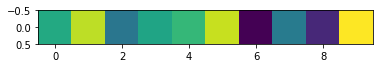

In [53]:
plt.imshow(tuning1_fano)

In [101]:
# get a transition matrix for consecutive days in the forward
# direction; i.e. for rank 10 tca: 10x10 matrix where each
# A[:,i] are ___________ factor was matched to output is a
# set of 10x10 matrices for each pair of days (so length is 1
# less than day number)

trans_mats = np.zeros((rank_num, rank_num,
                      len(factors_by_day)-1))
# CONSIDER MAKING THIS ONLY USE A LEADING OR LAGGING OR CENTERED WINDOW FOR COMPARISONS
for i in range(len(sim_mats_by_day)-1):
        
    # FORWARD day[i]-->day[i+1]

    # best match of day i components to day n
    step_out_lookup = np.argmax(sim_mats_by_day[i], axis=0)
    # best match of day n components to day i
    step_in_lookup = np.argmax(sim_mats_by_day[i+1], axis=1)
    # get transition matrix A[:,k], where k is comp number on
    # day i and A[j,k] is probability of compenent k being
    # matched to comp j on SUBSEQUENT day
    counter_mat = np.zeros((rank_num, rank_num))
    for k in range(rank_num):
        vec_out = step_out_lookup[k, :]
        for j in range(len(vec_out)):
            best_step_in = step_in_lookup[vec_out[j], j]
            counter_mat[best_step_in, k] += 1
    # aggregate results for all paired-day comparisons
    trans_mats[:, :, i] = counter_mat

    # --------------------------------------------------------

    # REVERSE day[i]<--day[i+1]

    # best match of day n components to day i (the opposite
    # comparison as FORWARD block)
    step_out_lookup2 = np.argmax(sim_mats_by_day[i+1], axis=0)
    # best match of day i components to day n
    step_in_lookup2 = np.argmax(sim_mats_by_day[i], axis=1)

    # get transition matrix A[:,k], where k is comp number on
    # day n (i+1) and A[j,k] is probability of compenent k being
    # matched to comp j on PREVIOUS day
    counter_mat2 = np.zeros((rank_num, rank_num))
    for k in range(rank_num):
        vec_out2 = step_out_lookup2[k, :]
        for j in range(len(vec_out2)):
            best_step_in2 = step_in_lookup2[vec_out2[j], j]
            counter_mat2[best_step_in2, k] += 1

    # transpose and add to counter_mat results, this should now
    # be in the same reference frame
#     trans_mats2[:,:,i] = counter_mat2.T
    trans_mats[:, :, i] += counter_mat2.T

# if you now divide this by day number *2 if added += above
# (number of comparisons) you should get a "probability" of a
# given transition
trans_mats = trans_mats/(len(sim_mats_by_day)*2)

# ------------------------------------------------------------

In [87]:
np.nansum(meta['speed'] > 10)

269

In [14]:
day_list

[170116,
 170118,
 170119,
 170125,
 170204,
 170206,
 170207,
 170208,
 170209,
 170210,
 170211,
 170214,
 170215,
 170216,
 170217,
 170220,
 170223,
 170224,
 170303,
 170308]

Text(0.5, 1.0, 'fanofactor similarity')

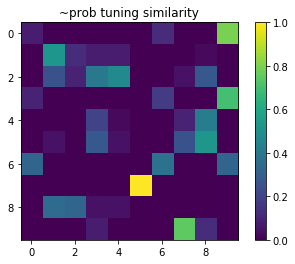

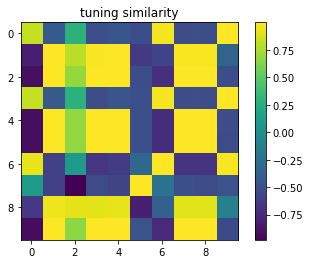

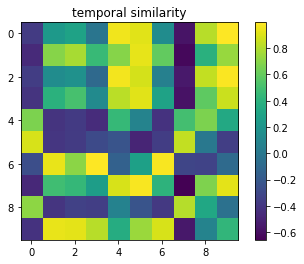

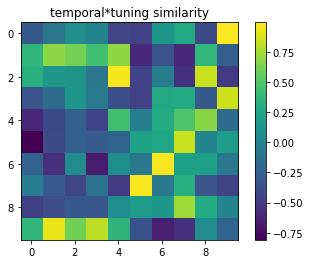

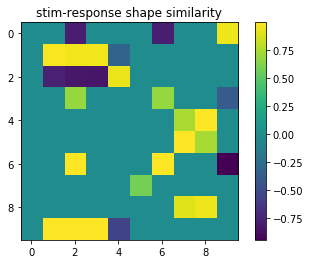

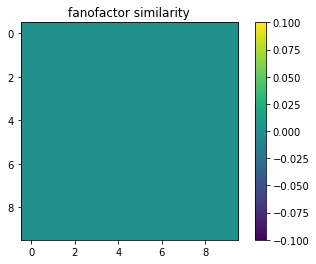

In [110]:
test_mats = [(a + b) for a, b in zip(on_sim_mats_by_day, off_sim_mats_by_day)]
test_mats = on_sim_mats_by_day
d = 18
plt.figure()
plt.imshow(trans_mats[:,:,d])
plt.colorbar()
plt.title('~prob tuning similarity')
plt.figure()
plt.imshow(tuning_sim_mats_by_day[d][:,:,d+1])
plt.colorbar()
plt.title('tuning similarity')
plt.figure()
plt.imshow(tempo_sim_mats_by_day[d][:,:,d+1])
plt.colorbar()
plt.title('temporal similarity')
plt.figure()
plt.imshow(tempo_sim_mats_by_day[d][:,:,d+1]*tuning_sim_mats_by_day[d][:,:,d+1])
plt.colorbar()
plt.title('temporal*tuning similarity')
plt.figure()
plt.imshow(np.multiply(on_sim_mats_by_day[d][:,:,d+1] + off_sim_mats_by_day[d][:,:,d+1],tuning_sim_mats_by_day[d][:,:,d+1]>0))
plt.title('stim-response shape similarity')
plt.colorbar()
plt.figure()
plt.imshow(np.multiply(fano_sim_mats_by_day[d][:,:,d+1],tuning_sim_mats_by_day[d][:,:,d+1]>0))
plt.colorbar()
plt.title('fanofactor similarity')

In [103]:
tempo_sim_mats_by_day[d][:,9,d+1]

array([ 0.99518533,  0.74001018,  0.98529288,  0.85998867,  0.34125478,
       -0.35153552, -0.08504698,  0.92987303, -0.04023256,  0.43145739])

In [35]:
np.multiply(fano_sim_mats_by_day[0][:,:,1],tuning_sim_mats_by_day[0][:,:,1]>0)[:,0]

array([0.        , 0.06138152, 0.        , 0.        , 0.        ,
       0.04643397, 0.        , 0.        , 0.        , 0.41873171])

# clustering factors by naive and late

In [123]:
meta

orientation  condition  trialerror  hunger  \
mouse date   run trial_idx                                               
OA27  170404 2   0                  135       plus           0  hungry   
                 1                    0      minus           4  hungry   
                 2                    0      minus           4  hungry   
                 3                  135       plus           0  hungry   
                 4                  135       plus           0  hungry   
                 5                  270    neutral           2  hungry   
                 6                  270    neutral           2  hungry   
                 7                  135       plus           0  hungry   
                 8                    0      minus           4  hungry   
                 9                  135  pavlovian           8  hungry   
                 10                 270    neutral           3  hungry   
                 11                 270    neutral           3  hungry   
                 12                 270    neutral           3  hungry   
                 13                   0      minus           4  hungry   
                 14                 135       plus           0  hungry   
                 15                 135       plus           0  hungry   
                 16                 270    neutral           3  hungry   
                 17                 135       plus           0  hungry   
                 18                   0      minus           4  hungry   
                 19                   0      minus           4  hungry   
                 20                   0      minus           4  hungry   
                 21                 270    neutral           2  hungry   
                 22                  -1      blank           6  hungry   
                 23                 270    neutral           2  hungry   
                 24                 270    neutral           2  hungry   
                 25                 135       plus           0  hungry   
                 26                   0      minus           4  hungry   
                 27                 135       plus           0  hungry   
                 28                 135       plus           0  hungry   
                 29                   0      minus           4  hungry   
...                                 ...        ...         ...     ...   
             4   119                270    neutral           3  hungry   
                 120                 -1      blank           7  hungry   
                 121                  0      minus           4  hungry   
                 122                135       plus           0  hungry   
                 123                270    neutral           2  hungry   
                 124                  0      minus           5  hungry   
                 125                  0      minus           5  hungry   
                 126                135       plus           0  hungry   
                 127                  0      minus           4  hungry   
                 128                135       plus           0  hungry   
                 129                135       plus           0  hungry   
                 130                270    neutral           2  hungry   
                 131                135       plus           0  hungry   
                 132                  0      minus           4  hungry   
                 133                  0      minus           4  hungry   
                 134                135       plus           0  hungry   
                 135                  0      minus           4  hungry   
                 136                  0      minus           4  hungry   
                 137                  0      minus           4  hungry   
                 138                135       plus           0  hungry   
                 139                270    neutral           2  hungry   
                 140            